In [1]:
import os
import math
import pandas as pd
import numpy as np
import seaborn as sns
from pandas import datetime
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [2]:
## convert one to multiple series
def lag_ahead_series(data, n_in=1, n_out=1, n_vars = 1,dropnan=True):
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for j in range(n_vars):
        for i in range(n_in, 0, -1):
            cols.append(df.iloc[:,j].shift(i))
            names.append('var{}(t-{})'.format(j+1, i))
    
    # forecast sequence (t+1, ... t+n)
    for j in range(n_vars):
        for i in range(0, n_out):
            cols.append(df.iloc[:,j].shift(-i))
            names += [('var{}(t+{})'.format(j+1, i)) ]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    #drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

## plot dataframe creation
def plot_df(arr, name):
    plot_df = pd.DataFrame()
    i = 0
    for row in arr:
        plot_df.insert(i, "{}".format(name), row, True) 
        i += 1
    return plot_df


In [4]:
train = pd.read_csv("../data/train_nocat_hh.csv", index_col= 'tstp')
test = pd.read_csv("../data/test_nocat_hh.csv", index_col= 'tstp')


In [6]:
train.head()

,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity,energy
tstp,,,,,,,,,
2011-11-23 09:00:00,4.390,229.0,4.840,4.68,1027.290,3.42,1.780,0.990,0.284500
2011-11-23 09:30:00,5.315,231.0,5.290,5.07,1027.480,3.83,1.885,0.985,0.280500
2011-11-23 10:00:00,6.240,233.0,5.740,5.46,1027.670,4.24,1.990,0.980,0.153333
2011-11-23 10:30:00,8.220,233.0,6.705,5.60,1027.615,5.09,2.325,0.930,0.098000
2011-11-23 11:00:00,10.200,233.0,7.670,5.74,1027.560,5.94,2.660,0.880,0.110286


In [8]:
#create 12 hours recency effect matrix
ahead_w = lag_ahead_series(train.iloc[:,2], n_in=0, n_out=25, n_vars = 1, dropnan=True)
#create 12 housrs ahead energy consumption matrix
ahead_e = lag_ahead_series(train.iloc[:,8:], n_in=0, n_out=25, n_vars = 1, dropnan=True)
ahead_w.shape, ahead_e.shape

((28726, 25), (28726, 25))

In [12]:
test_y = lag_ahead_series(test.iloc[:,8:], n_in=0, n_out=25, n_vars = 1, dropnan=True).iloc[:100,:]
test_X = lag_ahead_series(test.iloc[:,2], n_in=0, n_out=25, n_vars = 1, dropnan=True).iloc[:100,:]
test_X.shape, test_y.shape

((100, 25), (100, 25))

### TPOT

In [11]:
from tpot import TPOTRegressor
from tpot_multi import mul_reg_config_dict
from sklearn.model_selection import train_test_split
#import mul_config as mc

train_X, val_X, train_y, val_y = train_test_split(ahead_w, ahead_e, train_size = 0.05, test_size = 0.95, random_state = 123)

tpot_reg = TPOTRegressor(generations=30, 
                         population_size=60, 
                         n_jobs=4, 
                         verbosity=2, 
                         random_state=123,
                         subsample= 0.8,
                         config_dict=mul_reg_config_dict)
tpot_reg.fit(train_X , train_y)


Generation 1 - Current best internal CV score: -0.003541330212208537
Generation 2 - Current best internal CV score: -0.0034140088417746435
Generation 3 - Current best internal CV score: -0.0034140088417746435
Generation 4 - Current best internal CV score: -0.0034140088417746435
Generation 5 - Current best internal CV score: -0.0034140088417746435
Generation 6 - Current best internal CV score: -0.0034083484941096914
Generation 7 - Current best internal CV score: -0.0034083484941096914
Generation 8 - Current best internal CV score: -0.0033874187730924656
Generation 9 - Current best internal CV score: -0.0033315921731037605
Generation 10 - Current best internal CV score: -0.003330018721889499
Generation 11 - Current best internal CV score: -0.0033166343936228805
Generation 12 - Current best internal CV score: -0.0033166343936228805
Generation 13 - Current best internal CV score: -0.0032610586358913242
Generation 14 - Current best internal CV score: -0.0032610586358913242
Generation 15 - C

TPOTRegressor(config_dict={'sklearn.cluster.FeatureAgglomeration': {'affinity': ['euclidean',
                                                                                 'l1',
                                                                                 'l2',
                                                                                 'manhattan',
                                                                                 'cosine'],
                                                                    'linkage': ['ward',
                                                                                'complete',
                                                                                'average']},
                           'sklearn.decomposition.FastICA': {'tol': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])},
                           'sklearn.decomposition.PCA': {'iter

In [13]:
#val_X, val_y = train.iloc[500:600,:8], ahead_e.iloc[500:600,:]
yhat = tpot_reg.predict(test_X)

### Result Evaluation

**Mean Square Error**

In [14]:
mean_squared_error(test_y, yhat)

0.00032078067403312787

**Mean Absolute Error**

In [15]:
mean_absolute_error(test_y, yhat)

0.01406389608671403

**R2_score**

In [16]:
r2_score(test_y, yhat)

0.8304769005992318

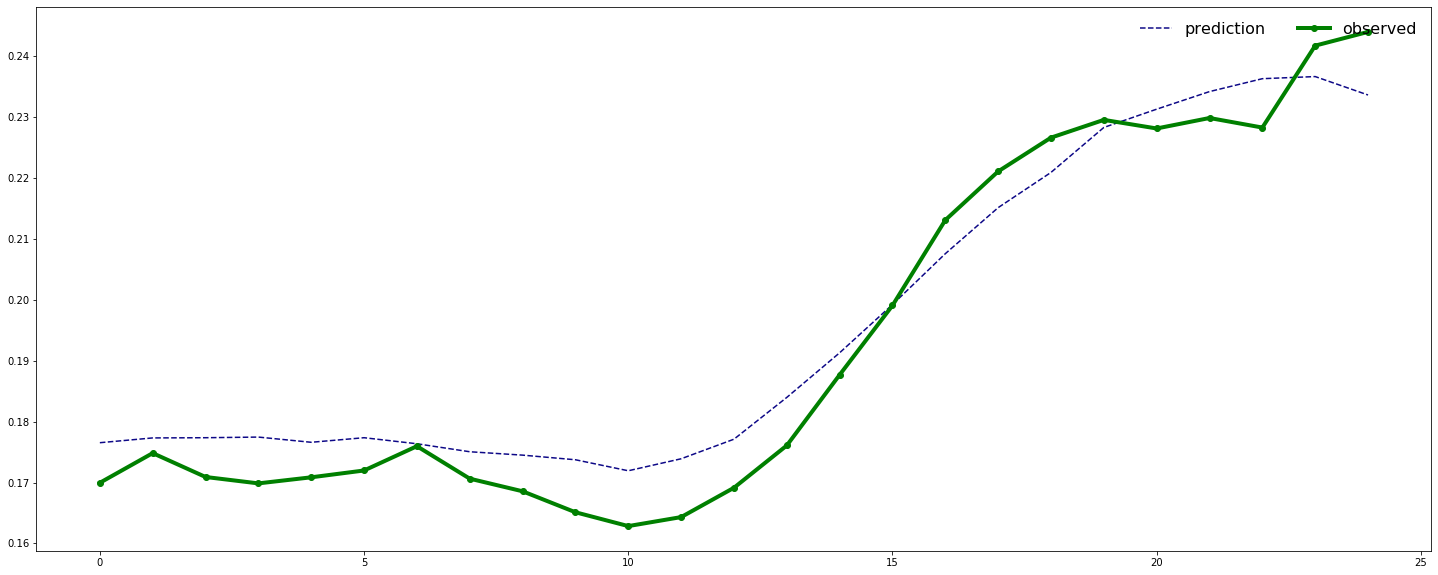

In [18]:
## assignment
real = test_y.to_numpy()
guess = yhat
real = real[50:51,:49]
guess = guess[50:51,:49]
rpdf = plot_df(real, "observed")
gpdf = plot_df(guess, "prediction")
    
#plot 
ax = plt.gca()
gpdf.plot(figsize=(25,10), colormap = 'plasma',style='--',legend = True, ax = ax)
rpdf.plot(figsize=(25,10), color = 'g',style ='-o',legend = True, ax = ax, lw = 4)
ax.legend(frameon=False, loc='upper right', ncol=6, prop={'size': 16})

plt.show()